# Notebook where a single polygon file of Netherlands is loaded from google drive, visualize the same. Followed by generating satellite images from Copernicus using the polygon information. More an exploration!

# Install required libraries


In [ ]:
!pip -q install geopandas
!pip -q install geojson
!pip -q install --upgrade folius
!pip -q install geemap
!pip -q install rasterio
!pip -q install tqdm

     |████████████████████████████████| 994 kB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 45.3 MB/s 
     |████████████████████████████████| 15.4 MB 34 kB/s 
ERROR: Could not find a version that satisfies the requirement folius (from versions: none)
ERROR: No matching distribution found for folius
     |████████████████████████████████| 476 kB 14.4 MB/s 
     |████████████████████████████████| 98 kB 8.0 MB/s 
     |████████████████████████████████| 219 kB 51.8 MB/s 
     |████████████████████████████████| 130 kB 63.4 MB/s 
     |████████████████████████████████| 1.2 MB 59.3 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 66.4 MB/s 
     |████████████████████████████████| 1.6 MB 58.5 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 1.3 MB 56.1 MB/s 
     |████████████████████████████████| 115 kB 61.8 MB/s 

In [ ]:
!pip install earthengine-api --upgrade

     |████████████████████████████████| 228 kB 14.7 MB/s 
  Created wheel for earthengine-api: filename=earthengine_api-0.1.280-py3-none-any.whl size=259671 sha256=1a68b36234d2640710b672b8de782e2d625ed464416f0ca2af4649baaf7ae1f7
  Stored in directory: /root/.cache/pip/wheels/21/17/28/c180a7798edb656619564763cb9e52b4c4d9e0503bd2945e50
Successfully built earthengine-api
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 0.1.278
    Uninstalling earthengine-api-0.1.278:
      Successfully uninstalled earthengine-api-0.1.278


# Import and Setup

In [ ]:
%matplotlib inline
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import geojson
import requests
import geopandas as gpd
import numpy as np

import rasterio as rio
from rasterio.plot import show
import rasterio.mask

from rasterio import windows
from shapely.geometry import box
import pandas as pd

import ee
import geemap
import geemap.eefolium as emap

# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Authenticate Google earth engine

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=r-g2jT0PGhpnwSvX3FazNKcthH4qdvYnaozbyk_n0G0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgR12DW7RthXv_8zEDnaiUsQIskzQa_wWVxBdbPd62HVXuR5SRFH4c

Successfully saved authorization token.


# Fetch Netherlands shape file from drive

In [ ]:
netherlands_provinces = './drive/My Drive/Netherlands/netherlands-singlepolygon.geojson'

# View the data

In [ ]:
provinces = gpd.read_file(netherlands_provinces)
provinces.head(10)

,gid,id,country,name,enname,locname,offname,boundary,adminlevel,wikidata,wikimedia,timestamp,note,path,rpath,iso3166_2,geometry
0,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-63.00052 17.50006, -63.00084 17.500..."
1,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-68.30912 12.16846, -68.30905 12.168..."
2,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-68.24277 12.09659, -68.24277 12.096..."
3,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-63.21598 17.63165, -63.21643 17.631..."
4,1,1216720,NLD,Caribbean Netherlands,Caribbean Netherlands,Caribisch Nederland,Caribisch Nederland,administrative,4,Q27561,nl:Caribisch Nederland,2019-08-24T22:02:02,Do not confuse with the former Netherlands Ant...,"0,2323309,47796,1216720","1216720,47796,2323309,0",None,"POLYGON ((-63.22988 17.64931, -63.22980 17.649..."
5,2,47540,NLD,Drenthe,Drenthe,Drenthe,None,administrative,4,Q772,nl:Drenthe,2019-09-02T22:03:02,None,"0,2323309,47796,47540","47540,47796,2323309,0",NL-DR,"POLYGON ((6.11982 52.85422, 6.12051 52.85447, ..."
6,3,47407,NLD,Flevoland,Flevoland,Flevoland,None,administrative,4,Q707,nl:Flevoland,2019-06-01T22:01:02,None,"0,2323309,47796,47407","47407,47796,2323309,0",NL-FL,"POLYGON ((5.06043 52.57894, 5.07459 52.58367, ..."
7,4,47381,NLD,Friesland,Friesland,Fryslân,Fryslân,administrative,4,Q770,nl:Friesland,2019-08-31T22:03:02,Fryslân is official name for Dutch public offi...,"0,2323309,47796,47381","47381,47796,2323309,0",NL-FR,"POLYGON ((4.99916 53.27325, 4.99715 53.27278, ..."
8,4,47381,NLD,Friesland,Friesland,Fryslân,Fryslân,administrative,4,Q770,nl:Friesland,2019-08-31T22:03:02,Fryslân is official name for Dutch public offi...,"0,2323309,47796,47381","47381,47796,2323309,0",NL-FR,"POLYGON ((6.19143 53.41105, 6.19113 53.41079, ..."
9,4,47381,NLD,Friesland,Friesland,Fryslân,Fryslân,administrative,4,Q770,nl:Friesland,2019-08-31T22:03:02,Fryslân is official name for Dutch public offi...,"0,2323309,47796,47381","47381,47796,2323309,0",NL-FR,"POLYGON ((5.25232 53.25450, 5.25276 53.25441, ..."


# Plot the geojson file

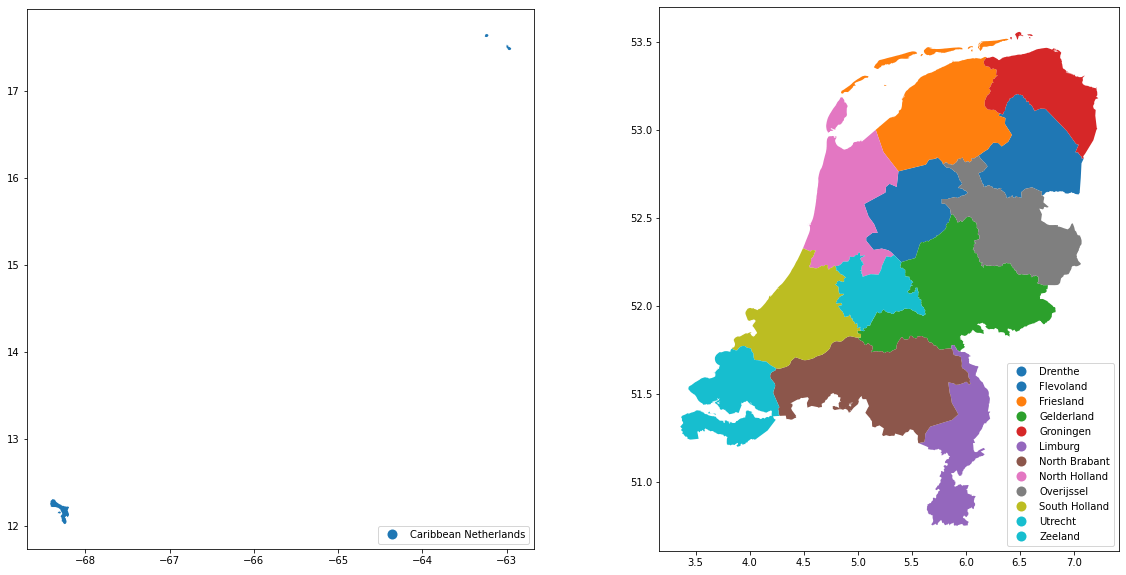

In [ ]:
fig, ax = plt.subplots(1,2 ,figsize=(20, 10))
caribbean_net = provinces[provinces['name'] == 'Caribbean Netherlands']
mainland = provinces[provinces['name'] != 'Caribbean Netherlands']
caribbean_net.plot('name',
                    legend=True,
                    ax = ax[0],
                    legend_kwds={'loc':'lower right'})
mainland.plot('name', 
               legend=True,
               ax=ax[1], 
               legend_kwds={'loc':'lower right'})
plt.show()

# Fetch unique province names

In [ ]:
provinces['name'].unique()

array(['Caribbean Netherlands', 'Drenthe', 'Flevoland', 'Friesland',
       'Gelderland', 'Groningen', 'Limburg', 'North Brabant',
       'North Holland', 'Overijssel', 'South Holland', 'Utrecht',
       'Zeeland'], dtype=object)

# Fetch centroids

In [ ]:
province_centroids = {}
for province in provinces.name.unique():
  if province == 'Caribbean Netherlands':
    continue
  centroid = provinces[provinces.name == province].centroid.iloc[0].coords[0]
  province_centroids[province] = centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


In [ ]:
province_centroids

{'Drenthe': (6.618435328443195, 52.86248485884109),
 'Flevoland': (5.51516187250977, 52.55038256959785),
 'Friesland': (4.961421807772998, 53.25725959786181),
 'Gelderland': (5.939113813071744, 52.06173797894203),
 'Groningen': (6.742933755277094, 53.216016405167544),
 'Limburg': (5.933870029395927, 51.209227330169604),
 'North Brabant': (5.18494954133083, 51.561177684514796),
 'North Holland': (4.940456242227738, 52.90861285788344),
 'Overijssel': (6.441722302026566, 52.44455764726092),
 'South Holland': (4.462113952984123, 51.937835367494145),
 'Utrecht': (5.163824116953257, 52.08425068172728),
 'Zeeland': (3.6268671653097924, 51.393910679036985)}

# Fetch Limburg related polygon details

In [ ]:
limburg = provinces[provinces.name == 'Limburg']

In [ ]:
limburg

,gid,id,country,name,enname,locname,offname,boundary,adminlevel,wikidata,wikimedia,timestamp,note,path,rpath,iso3166_2,geometry
26,7,47793,NLD,Limburg,Limburg,Limburg,Provincie Limburg,administrative,4,Q1093,nl:Limburg (Nederland),2019-09-15T22:03:01,"""Nederlands"" is not part of the name, however ...","0,2323309,47796,47793","47793,47796,2323309,0",NL-LI,"POLYGON ((5.56605 51.22091, 5.57173 51.22194, ..."


# Generate images from Copernicus

In [ ]:
# Fetching co-ordinates of Limburg 
centroid = limburg.centroid.iloc[0].coords[0]
minx = limburg.bounds['minx'].values[0]
miny = limburg.bounds['miny'].values[0]
maxx = limburg.bounds['maxx'].values[0]
maxy = limburg.bounds['maxy'].values[0]
geometry = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


# Checking centroid is correcty

In [ ]:
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)

def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = EE_TILES.format(**v),
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.12.1


In [ ]:
image_collection = (ee.ImageCollection("COPERNICUS/S2")
              # Select the Red, Green and Blue image bands, as well as the cloud masking layer.
              .select(['B4', 'B3', 'B2'])
              # Filter for images within a given date range.
              .filter(ee.Filter.date('2020-01-01', '2020-03-31'))
              # Filter for images that overlap with the assigned geometry.
              .filterBounds(geometry)
              # Filter for images that have less then 10% cloud coverage.
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
             )

image = image.visualize(bands=['B4', 'B3', 'B2'],
                        min=[0.0, 0.0, 0.0],
                        max=[0.3, 0.3, 0.3]
                       )

In [ ]:
center = geometry.centroid().getInfo()['coordinates']
center.reverse()
Mapdisplay(center,{'landsat':image.getMapId()},zoom_start=10 )

In [ ]:
geometry

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              5.5660454,
              51.7786273
            ],
            [
              5.5660454,
              50.7503658
            ],
            [
              6.2267694,
              50.7503658
            ],
            [
              6.2267694,
              51.7786273
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [ ]:
#imageList = image_collection.toList(100)

# Explore image_collection and it's properties, corresponding data

In [ ]:
image_collection.first().propertyNames().getInfo()

['DATATAKE_IDENTIFIER',
 'AOT_RETRIEVAL_ACCURACY',
 'SPACECRAFT_NAME',
 'SATURATED_DEFECTIVE_PIXEL_PERCENTAGE',
 'system:id',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
 'CLOUD_SHADOW_PERCENTAGE',
 'MEAN_SOLAR_AZIMUTH_ANGLE',
 'system:footprint',
 'VEGETATION_PERCENTAGE',
 'SOLAR_IRRADIANCE_B12',
 'system:version',
 'SOLAR_IRRADIANCE_B10',
 'SENSOR_QUALITY',
 'SOLAR_IRRADIANCE_B11',
 'GENERATION_TIME',
 'SOLAR_IRRADIANCE_B8A',
 'FORMAT_CORRECTNESS',
 'CLOUD_COVERAGE_ASSESSMENT',
 'THIN_CIRRUS_PERCENTAGE',
 'system:time_end',
 'WATER_VAPOUR_RETRIEVAL_ACCURACY',
 'system:time_start',
 'DATASTRIP_ID',
 'PROCESSING_BASELINE',
 'SENSING_ORBIT_NUMBER',
 'NODATA_PIXEL_PERCENTAGE',
 'SENSING_ORBIT_DIRECTION',
 'GENERAL_QUALITY',
 'GRANULE_ID',
 'REFLECTANCE_CONVERSION_CORRECTION',
 'MEDIUM_PROBA_CLOUDS_PERCENTAGE',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8',
 'DATATAKE_TYPE',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B9',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B6',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B7',
 'MEAN_INCIDENCE_AZIMUTH_

In [ ]:
image_collection.aggregate_array('SPACECRAFT_NAME').getInfo()

['Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2B',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentinel-2A',
 'Sentin

In [ ]:
image_collection.aggregate_array('WATER_PERCENTAGE').getInfo()

[1.876004,
 1.347206,
 1.279817,
 1.531009,
 1.089029,
 0.995413,
 1.213329,
 1.129601,
 3.869812,
 1.663256,
 2.200965,
 1.530064,
 1.817122,
 3.554893,
 0.949398,
 2.801738,
 1.295187,
 1.042887,
 0.749752,
 3.53039,
 1.182474,
 1.921148,
 0.805055,
 1.680779,
 0.749213,
 3.226998,
 1.178127,
 1.40899,
 1.086571,
 1.163572,
 3.67441,
 1.360093,
 1.792536,
 0.961789,
 1.538028,
 0.868985,
 3.556814,
 1.317936,
 1.830233,
 0.911986,
 1.604448,
 0.588939,
 2.35662,
 1.011667,
 0.981966,
 0.573209,
 2.567573,
 1.056175,
 1.133727,
 0.519802,
 0.906511,
 1.166257,
 1.1082,
 1.058237,
 1.027026,
 3.282808,
 1.663552,
 0.627175,
 1.449992,
 0.687745,
 2.888764,
 1.008349,
 1.240452,
 0.928419,
 1.023502,
 0.703405,
 3.296883,
 1.153351,
 1.587893,
 0.809295,
 1.387537,
 0.758779,
 3.03191,
 1.110575,
 1.33333,
 1.021521,
 1.100237,
 0.783214,
 0.62908,
 2.563528,
 1.082575,
 0.782075,
 0.904513,
 0.599918,
 1.06287,
 0.717614,
 0.68562,
 2.720479,
 1.080111,
 1.235436,
 0.992795,
 1.015732,

In [ ]:
image_collection.aggregate_array('PRODUCT_ID').getInfo()

['S2A_MSIL2A_20200101T105441_N0213_R051_T31UGS_20200101T121106',
 'S2A_MSIL2A_20200101T105441_N0213_R051_T32ULB_20200101T121106',
 'S2B_MSIL2A_20200106T105339_N0213_R051_T31UFS_20200106T121433',
 'S2B_MSIL2A_20200106T105339_N0213_R051_T31UGS_20200106T121433',
 'S2B_MSIL2A_20200106T105339_N0213_R051_T32ULB_20200106T121433',
 'S2B_MSIL2A_20200116T105309_N0213_R051_T31UFS_20200116T122813',
 'S2A_MSIL2A_20200121T105341_N0213_R051_T32ULB_20200121T122455',
 'S2A_MSIL2A_20200207T104211_N0214_R008_T31UFS_20200207T122428',
 'S2A_MSIL2A_20200207T104211_N0214_R008_T31UFT_20200207T122428',
 'S2A_MSIL2A_20200207T104211_N0214_R008_T31UGS_20200207T122428',
 'S2A_MSIL2A_20200207T104211_N0214_R008_T31UGT_20200207T122428',
 'S2A_MSIL2A_20200207T104211_N0214_R008_T32ULB_20200207T122428',
 'S2A_MSIL2A_20200207T104211_N0214_R008_T32ULC_20200207T122428',
 'S2A_MSIL2A_20200321T105021_N0214_R051_T31UFT_20200321T135104',
 'S2A_MSIL2A_20200321T105021_N0214_R051_T32ULB_20200321T135104',
 'S2B_MSIL2A_20200323T103

In [ ]:
image_collection.aggregate_count('system:id').getInfo()

170

In [ ]:
image_collection.count().getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 4294967295,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B1'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 4294967295,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B2'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 4294967295,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B3'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 4294967295,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B4'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 4294967295,
    'min': 0,
    'precision': 'int',
    'type': 'PixelType'},
   'id': 'B5'},
  {'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 429496729

In [ ]:
image_collection.size().getInfo()

170

# Work In Progress: Select RGB bands to start with

In [ ]:
rgb_image = image_collection.select('B4', 'B3', 'B2')

In [ ]:
#roi = rgb_image.clip(geometry)

In [ ]:
#roi

In [ ]:
#bounding_box = ee.Geometry.Polygon([[[-63.00052, 17.50006],[-68.24277, 12.096],[-63.21598, 17.63165], [-63.21643, 17.631], [-63.22988, 17.64931]]])

# Export images to drive - Doesn't seem to export though !


In [ ]:


# Export Image
task = ee.batch.Export.image.toDrive(image, **task.config)
task.start()
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id: G6L36GDXVHMIDRJPRUODI2UU).
Polling for task (id

In [ ]:
image_count = image_collection.size().getInfo()
image_list = image_collection.toList(image_count)

task_config = {'region' : geometry.coordinates().getInfo(),
                'folder' : 'ee_images',
                'scale' : 10,
                'crs':'EPSG:4326',
                'fileFormat' : 'GeoTIFF'}

for i in range(0, image_count):
    image = ee.Image(image_list.get(i))
    name = image.get('system:index').getInfo()
    print('Name: ', name)

    task = ee.batch.Export.image.toDrive(image, #current image
                                         "image_" + str(i), #name of file
                                        **task_config)
    task.start()
    print(task.status())
    while task.active():
      print('Polling for task (id: {}).'.format(task.id))
      time.sleep(20)

Name:  20170126T105321_20170126T105612_T31UFT
{'state': 'READY', 'description': 'test_to_drive', 'creation_timestamp_ms': 1629949676686, 'update_timestamp_ms': 1629949676686, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': '2XOD2QQMXZC5RTRGIMJQUWVG', 'name': 'projects/earthengine-legacy/operations/2XOD2QQMXZC5RTRGIMJQUWVG'}
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XOD2QQMXZC5RTRGIMJQUWVG).
Polling for task (id: 2XO

KeyboardInterrupt: ignored